## 一、定义前向、后向传播

本文将用numpy实现cnn, 并测试mnist手写数字识别

如果对神经网络的反向传播过程还有不清楚的，可以参考 [全连接层、损失函数的反向传播](0_1-全连接层、损失函数的反向传播.md)、[卷积层的反向传播](0_2_4-卷积层的反向传播-多通道、有padding、步长不为1.md)、[池化层的反向传播](0_2_5-池化层的反向传播-MaxPooling、AveragePooling、GlobalAveragePooling.md)

网络结构如下,包括1个卷积层,1个最大池化层，1个打平层2个全连接层：

input(1,28\*28)=> conv(1,3,3) => relu => max pooling => flatten => fc(64) => relu => fc(10)

这里定义卷积层只有一个输出通道,全连接层的神经元也只有64个神经元;主要是由于纯numpy的神经网络比较慢，本文主要目的理解神经网络的反向传播过程，以及如何用numpy实现神经网络，因此不追求设计最合适的网络结构;numpy实现的实现的神经网络无法应用到实际的项目中，请使用深度学习框架(如：Tensorflow、Keras、Caffe等)

In [6]:
# 定义权重、神经元、梯度
import numpy as np
weights = {}
weights_scale = 1e-2
filters = 1
fc_units=64
weights["K1"] = weights_scale * np.random.randn(1, filters, 3, 3).astype(np.float64)
weights["b1"] = np.zeros(filters).astype(np.float64)
weights["W2"] = weights_scale * np.random.randn(filters * 13 * 13, fc_units).astype(np.float64)
weights["b2"] = np.zeros(fc_units).astype(np.float64)
weights["W3"] = weights_scale * np.random.randn(fc_units, 10).astype(np.float64)
weights["b3"] = np.zeros(10).astype(np.float64)

# 初始化神经元和梯度
nuerons={}
gradients={}

In [7]:
# 定义前向传播和反向传播
from nn.layers import conv_backward,fc_forward,fc_backward
from nn.layers import flatten_forward,flatten_backward
from nn.activations import relu_forward,relu_backward
from nn.losses import cross_entropy_loss

import pyximport
pyximport.install()
from nn.clayers import conv_forward,max_pooling_forward,max_pooling_backward



# 定义前向传播
def forward(X):
    nuerons["conv1"]=conv_forward(X.astype(np.float64),weights["K1"],weights["b1"])
    nuerons["conv1_relu"]=relu_forward(nuerons["conv1"])
    nuerons["maxp1"]=max_pooling_forward(nuerons["conv1_relu"].astype(np.float64),pooling=(2,2))

    nuerons["flatten"]=flatten_forward(nuerons["maxp1"])
    
    nuerons["fc2"]=fc_forward(nuerons["flatten"],weights["W2"],weights["b2"])
    nuerons["fc2_relu"]=relu_forward(nuerons["fc2"])
    
    nuerons["y"]=fc_forward(nuerons["fc2_relu"],weights["W3"],weights["b3"])

    return nuerons["y"]

# 定义反向传播
def backward(X,y_true):
    loss,dy=cross_entropy_loss(nuerons["y"],y_true)
    gradients["W3"],gradients["b3"],gradients["fc2_relu"]=fc_backward(dy,weights["W3"],nuerons["fc2_relu"])
    gradients["fc2"]=relu_backward(gradients["fc2_relu"],nuerons["fc2"])
    
    gradients["W2"],gradients["b2"],gradients["flatten"]=fc_backward(gradients["fc2"],weights["W2"],nuerons["flatten"])
    
    gradients["maxp1"]=flatten_backward(gradients["flatten"],nuerons["maxp1"])
       
    gradients["conv1_relu"]=max_pooling_backward(gradients["maxp1"].astype(np.float64),nuerons["conv1_relu"].astype(np.float64),pooling=(2,2))
    gradients["conv1"]=relu_backward(gradients["conv1_relu"],nuerons["conv1"])
    gradients["K1"],gradients["b1"],_=conv_backward(gradients["conv1"],weights["K1"],X)
    return loss

In [8]:
# 获取精度
def get_accuracy(X,y_true):
    y_predict=forward(X)
    return np.mean(np.equal(np.argmax(y_predict,axis=-1),
                            np.argmax(y_true,axis=-1)))

## 二、加载数据

mnist.pkl.gz数据源： http://deeplearning.net/data/mnist/mnist.pkl.gz   

In [9]:
from nn.load_mnist import load_mnist_datasets
from nn.utils import to_categorical
train_set, val_set, test_set = load_mnist_datasets('mnist.pkl.gz')
train_x,val_x,test_x=np.reshape(train_set[0],(-1,1,28,28)),np.reshape(val_set[0],(-1,1,28,28)),np.reshape(test_set[0],(-1,1,28,28))
train_y,val_y,test_y=to_categorical(train_set[1]),to_categorical(val_set[1]),to_categorical(test_set[1])

In [10]:
# 随机选择训练样本
train_num = train_x.shape[0]
def next_batch(batch_size):
    idx=np.random.choice(train_num,batch_size)
    return train_x[idx],train_y[idx]

x,y= next_batch(16)
print("x.shape:{},y.shape:{}".format(x.shape,y.shape))

x.shape:(16, 1, 28, 28),y.shape:(16, 10)


## 三、训练网络

由于numpy卷积层层前向、后向过程较慢,这里只迭代2000步,mini-batch设置为2;实际只训练了4000个样本(也有不错的精度,增加迭代次数精度会继续提升;增加卷积层输出通道数，精度上限也会提升);总样本有5w个。

In [11]:

from nn.optimizers import SGD
# 初始化变量
batch_size=2
steps = 2000

# 更新梯度
sgd=SGD(weights,lr=0.01,decay=1e-6)

for s in range(steps):
    X,y=next_batch(batch_size)

    # 前向过程
    forward(X)
    # 反向过程
    loss=backward(X,y)


    sgd.iterate(weights,gradients)

    if s % 100 ==0:
        print("\n step:{} ; loss:{}".format(s,loss))
        idx=np.random.choice(len(val_x),200)
        print(" train_acc:{};  val_acc:{}".format(get_accuracy(X,y),get_accuracy(val_x[idx],val_y[idx])))

print("\n final result test_acc:{};  val_acc:{}".
      format(get_accuracy(test_x,test_y),get_accuracy(val_x,val_y)))


 step:0 ; loss:2.3025710785961633
 train_acc:0.5;  val_acc:0.105

 step:100 ; loss:2.322658576777174
 train_acc:0.0;  val_acc:0.135

 step:200 ; loss:2.2560641373902453
 train_acc:0.0;  val_acc:0.15

 step:300 ; loss:2.1825470524006914
 train_acc:1.0;  val_acc:0.105

 step:400 ; loss:2.208445091755495
 train_acc:0.0;  val_acc:0.12

 step:500 ; loss:1.413758817626698
 train_acc:0.5;  val_acc:0.475

 step:600 ; loss:0.8138671602711395
 train_acc:1.0;  val_acc:0.605

 step:700 ; loss:0.040969240382020794
 train_acc:1.0;  val_acc:0.695

 step:800 ; loss:0.2943919590130214
 train_acc:1.0;  val_acc:0.8

 step:900 ; loss:0.7937038773889639
 train_acc:0.5;  val_acc:0.775

 step:1000 ; loss:0.20416262923266468
 train_acc:1.0;  val_acc:0.82

 step:1100 ; loss:3.492562642433139
 train_acc:0.5;  val_acc:0.755

 step:1200 ; loss:0.44327566847604044
 train_acc:1.0;  val_acc:0.81

 step:1300 ; loss:0.381620659555296
 train_acc:1.0;  val_acc:0.78

 step:1400 ; loss:0.1379428630137357
 train_acc:1.0; 

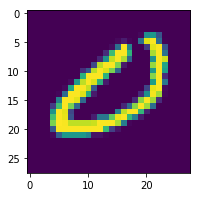

y_true:0,y_predict:0


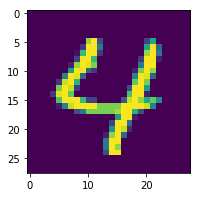

y_true:4,y_predict:4


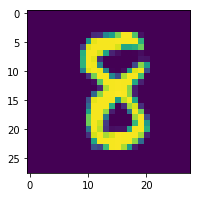

y_true:8,y_predict:8


In [22]:
# 随机查看预测结果
import matplotlib.pyplot as plt

idx=np.random.choice(test_x.shape[0],3)
x,y=test_x[idx],test_y[idx]
y_predict = forward(x)
for i in range(3):
    plt.figure(figsize=(3,3))
    plt.imshow(np.reshape(x[i],(28,28)))
    plt.show()
    print("y_true:{},y_predict:{}".format(np.argmax(y[i]),np.argmax(y_predict[i])))